In [22]:
%matplotlib inline
import json
import pandas as pd
import seaborn as sns
import im2gps.services.localisation as localisation
import matplotlib.pyplot as plt

from im2gps.data.descriptors import DescriptorsTable
from im2gps.lib.localisation import build_index
from im2gps.conf.config import load_config

In [2]:
cfg = load_config(["config-local.yaml"])
path_to_db = cfg.data.datasets.train
path_to_queries = cfg.data.datasets.validation_queries

db = DescriptorsTable(path_to_db, 2048)
val_queries = DescriptorsTable(path_to_queries, 2048)

In [3]:
index=build_index(db)
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7fa6ab6b8c60> >

# Chosing parametrs for KDE

In order to select parameters for KDE, I'll perform grid search. And I've chosen k as increments of 10 and sigma based on a thought that the kernel used in KDE is a normal distribution of coordinates, and approx. 1km distance correspond to 0.01 degrees change in coordinates, then smallest sigma 0.00001 correspond to 1m distance.

In [21]:
def grid_search(grid, queries):
    results = {}
    for k in grid['k']:
        results[k] = {}
        for sigma in grid['sigma']:
            print(f"k={k}, sigma={sigma}")
            acc, err, _ = localisation.run_test(index, db,queries,k,loc_type='kde', sigma=sigma, m=5)
            results[k][sigma] = {'acc': acc, 'err':err}
    return results

In [ ]:
grid = {'k':[10, 20, 30, 40, 50, 60, 80 ,100], 
        'sigma': [0.00001, 0.00005, 0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01]}

results = grid_search(grid)
with open('output/kde_val_results.json', 'w') as f:
    json.dump(results, f)

In [ ]:
header = ['acc', 'scale', 'k', 'sigma']

with open('output/kde_val_results.json','r') as f:
    results = json.load(f)

data =[]
for k in results:
    for sigma in results[k]:
        for scale in results[k][sigma]['acc']:
            row = [results[k][sigma]['acc'][scale], scale,k,sigma]
            data.append(row)
data = pd.DataFrame(data, columns=header)

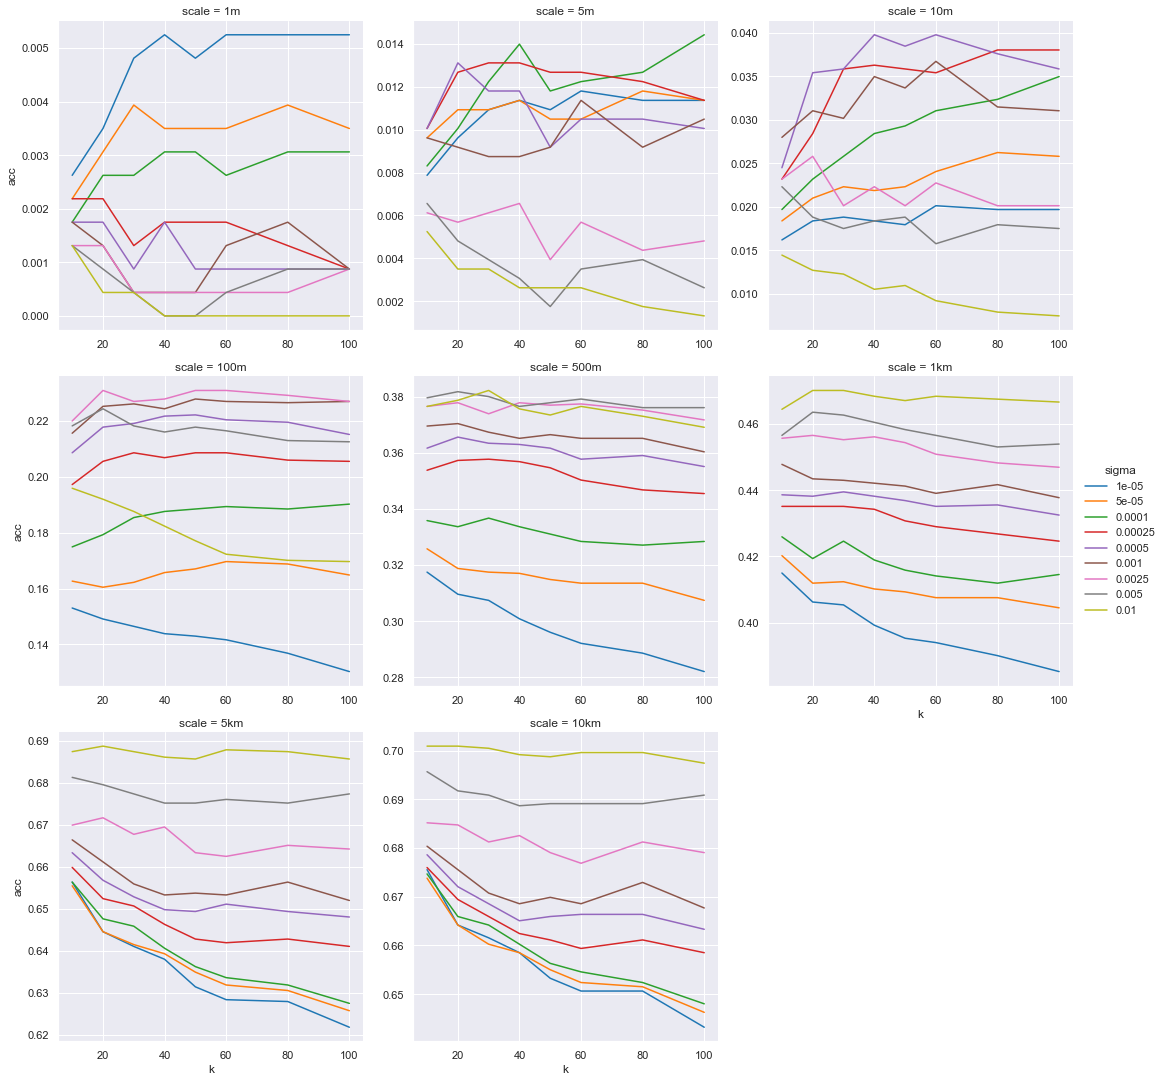

In [38]:
sns.set_style('darkgrid')
sns.relplot(
    data=data,
    x='k', y='acc', col='scale', hue='sigma', marker
    kind='line', palette=sns.color_palette('tab10',9), col_wrap=3, facet_kws={'sharey':False, 'sharex':False}
)

## Best params for different scales
for 500m+ scale good option seems like sigma=0.01 and k=30

for 100m scale sigma=0.0025 and k=20

for 10m scale sigma=0.0005 and k=40

for 5m scale sigma=0.0001 and k=30

for 1m scale sigma=0.00001 and k=40

In [4]:
val_queries.close()

# Comparison of different methods

Here I'll compare and analyse results of 1nn localisation and localisation with NN and KDE with different parameters.

In [5]:
path_to_queries = cfg.data.datasets.test_queries
test_queries = DescriptorsTable(path_to_queries, 2048)

Let's get the results for 1nn localisation. 

In [6]:
k=1
acc_1nn,err_1nn,geo_err_1nn = localisation.run_test(index, db,test_queries,k,loc_type='1nn')
print(json.dumps(acc_1nn,indent=2))
print(json.dumps(err_1nn,indent=2))

{
  "1m": 0.0026030368763557484,
  "5m": 0.00824295010845987,
  "10m": 0.024295010845986984,
  "100m": 0.17787418655097614,
  "500m": 0.36789587852494576,
  "1km": 0.4789587852494577,
  "5km": 0.7097613882863341,
  "10km": 0.721475054229935
}
{
  "0m to 1m": 0.00012972759364718236,
  "1m to 5m": 0.003949456612889587,
  "5m to 10m": 0.007582786117945228,
  "10m to 100m": 0.046833975653063034,
  "100m to 500m": 0.26209035252141205,
  "500m to 1km": 0.7248146944410977,
  "1km to 5km": 2.0163013165913397,
  "5km to 10km": 6.9423999442971285,
  "10km+": 578.8564928880315
}


First output shows accuracy of the algorithm for different levels, second output shows average distance from true query location to predicted location, the distance is in kilometers.

Reasonable accuracy for mobile GPS is around 10m to 100m, however we see that only 17.7% of queries localised with such accuracy, while around 47% localised with 1km accuracy, which is quite big margin for 
city environment.

Let's see if density density of photos in query location affects localisation accuracy. I calculate a density as number of photos within 1km radius from query location.

In [42]:
with open('output/image-densities.json','r') as f:
    densities = json.load(f)

header = ['density', 'dist_err']
data = [[dens,err] for dens, err in zip(densities,geo_err_1nn)]
dens_1nn = pd.DataFrame(data, columns=header)

In [43]:
dens_1nn.describe()

,density,dist_err
count,2305.000000,2305.000000
mean,29645.695879,161.910302
std,28232.105777,954.340974
min,1.000000,0.000000
25%,837.000000,0.202896
50%,20520.000000,1.122213
75%,61522.000000,43.510618
max,74874.000000,16990.267617


Text(0.5, 1.0, 'Error vs Density, 1km scale')

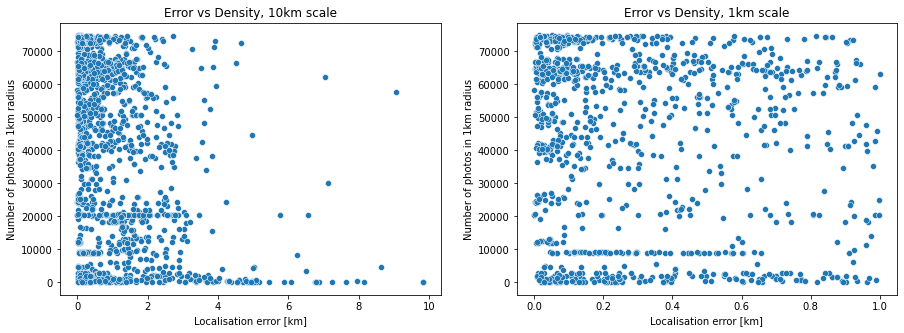

In [54]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
sns.scatterplot(data=dens_1nn[dens_1nn['dist_err']<=10], x="dist_err", y="density", ax=ax1)
ax1.set_xlabel("Localisation error [km]")
ax1.set_ylabel("Number of photos in 1km radius")
ax1.set_title("Error vs Density, 10km scale")
sns.scatterplot(data=dens_1nn[dens_1nn['dist_err']<=1], x="dist_err", y="density", ax=ax2)
ax2.set_xlabel("Localisation error [km]")
ax2.set_ylabel("Number of photos in 1km radius")
ax2.set_title("Error vs Density, 1km scale")

From the graphs above it seems that higher localisation error accures even in dense regions

In [55]:
k=30
sigma=0.00025
acc_kde_25, err_kde_25, geo_err_kde_25 = localisation.run_test(index, db,test_queries,k,loc_type='kde', sigma=sigma, m=5)
print(json.dumps(acc_kde_25,indent=2))
print(json.dumps(err_kde_25,indent=2))

{
  "1m": 0.003036876355748373,
  "5m": 0.011279826464208243,
  "10m": 0.0386117136659436,
  "100m": 0.23947939262472884,
  "500m": 0.41301518438177875,
  "1km": 0.502819956616052,
  "5km": 0.6984815618221258,
  "10km": 0.7149674620390456
}
{
  "0m to 1m": 0.00033563299863847605,
  "1m to 5m": 0.003728099033201593,
  "5m to 10m": 0.007562908724620037,
  "10m to 100m": 0.041182616814178494,
  "100m to 500m": 0.25893732996974117,
  "500m to 1km": 0.7202367594804596,
  "1km to 5km": 1.9922613168710657,
  "5km to 10km": 7.232982308312468,
  "10km+": 550.5770981730524
}


In [57]:
k=40
sigma=0.0005
acc_kde_50, err_kde_50, geo_err_kde_50 = localisation.run_test(index, db,test_queries,k,loc_type='kde', sigma=sigma, m=5)
print(json.dumps(acc_kde_50,indent=2))
print(json.dumps(err_kde_50,indent=2))

{
  "1m": 0.0026030368763557484,
  "5m": 0.013015184381778741,
  "10m": 0.041648590021691974,
  "100m": 0.25553145336225597,
  "500m": 0.4299349240780911,
  "1km": 0.516702819956616,
  "5km": 0.6997830802603037,
  "10km": 0.7136659436008677
}
{
  "0m to 1m": 0.0002718443224321915,
  "1m to 5m": 0.003509009501086121,
  "5m to 10m": 0.007768149159452741,
  "10m to 100m": 0.041175312229677505,
  "100m to 500m": 0.2616896533738089,
  "500m to 1km": 0.7245881237027751,
  "1km to 5km": 1.976542419388975,
  "5km to 10km": 7.136565580629686,
  "10km+": 537.3240184234668
}


Let's compare performance of different methods

Text(0.5, 0, 'Localisation scale')

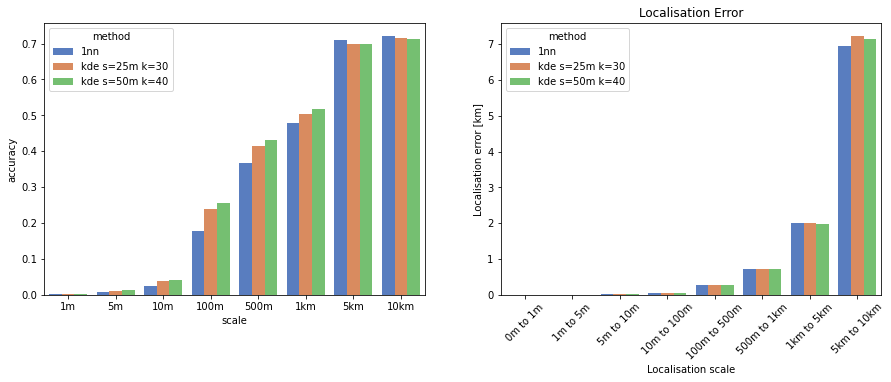

In [100]:
data_dicts = [{'method': '1nn', 'acc':acc_1nn, 'err': err_1nn},{'method': 'kde s=25m k=30', 'acc':acc_kde_25, 'err': err_kde_25},{'method': 'kde s=50m k=40', 'acc':acc_kde_50, 'err': err_kde_50}]
data_acc = []
data_err = []
for data_dict in data_dicts:
    method =data_dict['method']
    for scale, acc in data_dict['acc'].items():
        data_acc.append([method, scale, acc])
    for scale, err in data_dict['err'].items():
        if scale == "10km+":
            continue
        data_err.append([method, scale, err])
        
df_acc = pd.DataFrame(data_acc, columns=['method', 'scale', 'accuracy'])
df_err = pd.DataFrame(data_err, columns=['method', 'scale', 'error'])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
sns.barplot(data=df_acc, x='scale', y='accuracy', hue='method', palette='muted', ax=ax1)
ax2.set_title("Localisation Accuracy")
ax2.set_ylabel("Localisation accuracy [km]")
ax2.set_xlabel("Localisation scale")
sns.barplot(data=df_err, x='scale', y='error', hue='method', palette='muted', ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=45)
ax2.set_title("Localisation Error")
ax2.set_ylabel("Localisation error [km]")
ax2.set_xlabel("Localisation scale")


Now let's plot density vs error plot for knn with kde

In [97]:

data = [[dens,err] for dens, err in zip(densities,geo_err_kde_50)]
dens_kde = pd.DataFrame(data, columns=['density','dist_err'])

In [98]:
dens_kde.describe()

,density,dist_err
count,2305.000000,2305.000000
mean,29645.695879,154.432685
std,28232.105777,860.032682
min,1.000000,0.000000
25%,837.000000,0.092573
50%,20520.000000,0.872507
75%,61522.000000,51.570599
max,74874.000000,16685.144155


Text(0.5, 1.0, 'Error vs Density, 1km scale')

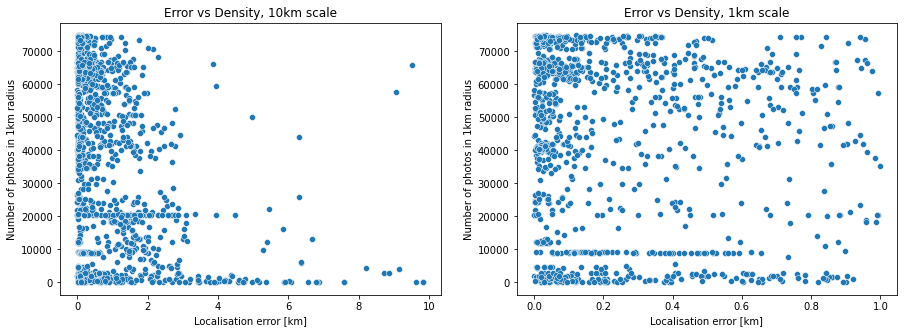

In [102]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
sns.scatterplot(data=dens_kde[dens_kde['dist_err']<=10], x="dist_err", y="density", ax=ax1)
ax1.set_xlabel("Localisation error [km]")
ax1.set_ylabel("Number of photos in 1km radius")
ax1.set_title("Error vs Density, 10km scale")
sns.scatterplot(data=dens_kde[dens_kde['dist_err']<=1], x="dist_err", y="density", ax=ax2)
ax2.set_xlabel("Localisation error [km]")
ax2.set_ylabel("Number of photos in 1km radius")
ax2.set_title("Error vs Density, 1km scale")

And finally compare density vs error for 1nn and knn with kde

Text(0.5, 1.0, 'Error vs Density, 1km scale, 1NN')

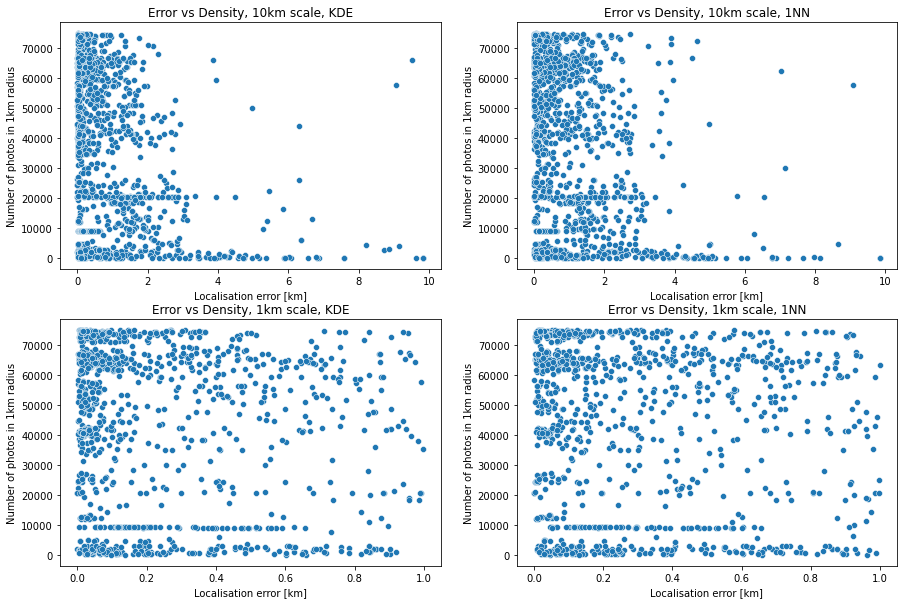

In [106]:
fig,axs = plt.subplots(2,2, figsize=(15,10))
sns.scatterplot(data=dens_kde[dens_kde['dist_err']<=10], x="dist_err", y="density", ax=axs[0,0])
axs[0,0].set_xlabel("Localisation error [km]")
axs[0,0].set_ylabel("Number of photos in 1km radius")
axs[0,0].set_title("Error vs Density, 10km scale, KDE")

sns.scatterplot(data=dens_1nn[dens_1nn['dist_err']<=10], x="dist_err", y="density", ax=axs[0,1])
axs[0,1].set_xlabel("Localisation error [km]")
axs[0,1].set_ylabel("Number of photos in 1km radius")
axs[0,1].set_title("Error vs Density, 10km scale, 1NN")

sns.scatterplot(data=dens_kde[dens_kde['dist_err']<=1], x="dist_err", y="density", ax=axs[1,0])
axs[1,0].set_xlabel("Localisation error [km]")
axs[1,0].set_ylabel("Number of photos in 1km radius")
axs[1,0].set_title("Error vs Density, 1km scale, KDE")

sns.scatterplot(data=dens_1nn[dens_1nn['dist_err']<=1], x="dist_err", y="density", ax=axs[1,1])
axs[1,1].set_xlabel("Localisation error [km]")
axs[1,1].set_ylabel("Number of photos in 1km radius")
axs[1,1].set_title("Error vs Density, 1km scale, 1NN")

In [30]:
db.close()
test_queries.close()